In [5]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pretty_midi
import librosa
import mir_eval
import mir_eval.display
import tables
import IPython.display
import os
import json
import functools
import math
import pandas as pd
from matplotlib.ticker import PercentFormatter

# Most of this code was taken from the Lakh MIDI Dataset Tutorial: https://nbviewer.org/github/craffel/midi-dataset/blob/master/Tutorial.ipynb

# Local path constants
DATA_PATH = 'data'
RESULTS_PATH = 'results'
# Path to the file match_scores.json distributed with the LMD
SCORE_FILE = os.path.join(RESULTS_PATH, 'match_scores.json')
MAX_MSD_ID = 31033

# Utility functions for retrieving paths
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

def msd_id_to_mp3(msd_id):
    """Given an MSD ID, return the path to the corresponding mp3"""
    return os.path.join(DATA_PATH, 'msd', 'mp3',
                        msd_id_to_dirs(msd_id) + '.mp3')

def msd_id_to_h5(msd_id):
    """Given an MSD ID, return the path to the corresponding h5"""
    return os.path.join(RESULTS_PATH, 'lmd_matched_h5',
                        msd_id_to_dirs(msd_id) + '.h5')

def get_midi_path(msd_id, midi_md5, kind):
    """Given an MSD ID and MIDI MD5, return path to a MIDI file.
    kind should be one of 'matched' or 'aligned'. """
    return os.path.join(RESULTS_PATH, 'lmd_{}'.format(kind),
                        msd_id_to_dirs(msd_id), midi_md5 + '.mid')

def convert_bytestring_to_string(bytestring):
    return bytestring.decode('utf-8')

c = convert_bytestring_to_string

print(SCORE_FILE)

results\match_scores.json


In [ ]:
# Attempting to find a list of all unique artist terms:
with open(SCORE_FILE) as f:
    scores = json.load(f)

unique_ids = []
artist_terms_file = open(os.path.join(RESULTS_PATH, 'top_artist_term_output.txt'), "w")

for id in range(0, MAX_MSD_ID + 1):
    msd_id = list(scores.keys())[id]
    with tables.open_file(msd_id_to_h5(msd_id)) as h5:
        curr_artist_terms = map(convert_bytestring_to_string, list(h5.root.metadata.artist_terms))
        curr_artist_terms = list(curr_artist_terms)
        if len(curr_artist_terms) > 0:
            if curr_artist_terms[0] not in unique_ids:
                unique_ids.append(curr_artist_terms[0])
                artist_terms_file.write(curr_artist_terms[0] + '\n')


In [6]:
# Search songs by artist_name (for testing)
with open(SCORE_FILE) as f:
    scores = json.load(f)

def search_for_song_by(artist_name):
    def get_curr_artist(curr_msd_id):
        with tables.open_file(msd_id_to_h5(curr_msd_id)) as file:
            curr_artist = c(file.root.metadata.songs.cols.artist_name[0])
            return curr_artist
    
    songs = []
    songs_file = open(os.path.join(RESULTS_PATH, 'song_search_output.txt'), "w")
    for id in range(0, MAX_MSD_ID + 1):
        curr_msd_id = list(scores.keys())[id]
        curr_artist = get_curr_artist(curr_msd_id)
        if (artist_name == curr_artist):
            songs.append(curr_msd_id)
            songs_file.write(curr_msd_id + '\n')
    print('Found {} songs by {} in the MSD'.format(len(songs), artist_name))
    for song in songs:
        with tables.open_file(msd_id_to_h5(song)) as file:
            print('{} with MSD ID: {}'.format(
                c(file.root.metadata.songs.cols.title[0]),
                song
            )
        )


In [3]:
# Get metadata of a song with MSD ID msd_id
def get_metadata(msd_id):
    with tables.open_file(msd_id_to_h5(msd_id)) as h5:
        print('ID: {}'.format(msd_id))
        print('"{}" by {} on "{}"'.format(
            c(h5.root.metadata.songs.cols.title[0]),
            c(h5.root.metadata.songs.cols.artist_name[0]),
            c(h5.root.metadata.songs.cols.release[0])))
        print('Top 5 artist terms:', ', '.join(map(c, list(h5.root.metadata.artist_terms)[:5])))

# Finding the highest confidence MIDI MD5 given an MSD ID 
def get_closest_midi_md5(msd_id):
    with open(SCORE_FILE) as f:
        scores = json.load(f)

        max_confidence_md5 = None
        max_score = 0
        for midi_md5, score in scores[msd_id].items():
            if score > max_score:
                max_score = score
                max_confidence_md5 = midi_md5
        return max_confidence_md5


In [9]:
# For finding frequency of occurrence of melodic intervals in a MIDI
def frequency_of_intervals(midi_dir):
    intervals = list(range(0, 13))
    interval_dict = {intervals[i]: 0 for i in range(0, len(intervals))}
    midi_data = pretty_midi.PrettyMIDI(midi_dir)
    for i in range(0, len(midi_data.instruments)):
        instrument = midi_data.instruments[i]
        if not instrument.is_drum:
            prev_note = instrument.notes[0]
            for note in instrument.notes[1:]:
                if note.start != prev_note.start:
                    interval = abs(note.pitch - prev_note.pitch)
                    if interval in interval_dict:
                        interval_dict[interval] += 1
                    prev_note = note
            
    return interval_dict

# For finding amounts of ascending and descending intervals in a MIDI
def proportion_of_ascending_intervals(midi_dir):
    intervals = list(range(1, 13))
    create_interval_dict = lambda: {intervals[i]: 0 for i in range(0, len(intervals))}
    dict = {"ascending": create_interval_dict(), "descending": create_interval_dict()}
    midi_data = pretty_midi.PrettyMIDI(midi_dir)
    for i in range(0, len(midi_data.instruments)):
        instrument = midi_data.instruments[i]
        if not instrument.is_drum:
            prev_note = instrument.notes[0]
            for note in instrument.notes[1:]:
                if note.start != prev_note.start:
                    interval = note.pitch - prev_note.pitch
                    if interval != 0 and interval >= -12 and interval <= 12:
                        key = "ascending"
                        if interval < 0:
                            key = "descending"
                        dict[key][abs(interval)] += 1
                    prev_note = note
    return dict

# For calculating proportions for step-step movements in a song
def step_step_movement_proportions(midi_dir):
    create_dict = lambda: {"ascending": 0, "descending": 0}
    dict = {"ascending": create_dict(), "descending": create_dict()}
    midi_data = pretty_midi.PrettyMIDI(midi_dir)
    for i in range(0, len(midi_data.instruments)):
        instrument = midi_data.instruments[i]
        if not instrument.is_drum:
            prev_note = instrument.notes[0]
            prev_interval_type = ""
            for note in instrument.notes[1:]:
                if note.start != prev_note.start:
                    interval = note.pitch - prev_note.pitch
                    curr_interval_type = ""
                    if interval != 0:
                        if interval > 0:
                            curr_interval_type = "ascending"
                        else:
                            curr_interval_type = "descending"
                        if prev_interval_type != "":
                            dict[prev_interval_type][curr_interval_type] += 1
                        else:
                            if interval <= 2 and interval >= -2:
                                prev_interval_type = curr_interval_type
                            else:
                                prev_interval_type = ""
                    prev_note = note
    return dict

# For calculating stats on the types of melodic leaps relative to the median pitch
def melodic_leap_stats(midi_dir):

    def calculate_median_pitch(instrument):
        all_notes = []
        prev_note = instrument.notes[0]
        for note in instrument.notes[1:]:
            if note.start != prev_note.start:
                all_notes.append(note.pitch)
                prev_note = note
        if not np.isnan(np.nanmedian(all_notes)):
            return math.floor(np.nanmedian(all_notes))
    
    create_dict = lambda: {"reverse": 0, "same": 0}
    dict = {"median-departing": create_dict(), "median-crossing": create_dict(), 
            "median-landing": create_dict(), "median-approaching": create_dict()}
    midi_data = pretty_midi.PrettyMIDI(midi_dir)
    for instrument in midi_data.instruments:
        if not instrument.is_drum:
            median = calculate_median_pitch(instrument)
            if not median:
                continue
            prev_interval_type = ""
            prev_leap_type = ""
            prev_note = instrument.notes[0]
            for note in instrument.notes[1:]:
                interval = note.pitch - prev_note.pitch
                
                if interval == 0 or note.start == prev_note.start:
                    continue
                
                curr_interval_type = ""
                if interval < 0:
                    curr_interval_type = "descending"
                else: 
                    curr_interval_type = "ascending"
                # checking for leaps
                curr_leap_type = ""
                if interval > 2 or interval < -2:
                    # classifying current leap type
                    if curr_interval_type == "ascending":
                        if prev_note.pitch >= median:
                            curr_leap_type = "median-departing"
                        elif prev_note.pitch < median and note.pitch > median: 
                            curr_leap_type = "median-crossing"
                        elif note.pitch < median:
                            curr_leap_type = "median-approaching"
                        else:
                            curr_leap_type = "median-landing"
                    if curr_interval_type == "descending":
                        if prev_note.pitch <= median:
                            curr_leap_type = "median-departing"
                        elif prev_note.pitch > median and note.pitch < median:
                            curr_leap_type = "median-crossing"
                        elif prev_note.pitch > median:
                            curr_leap_type = "median-approaching"
                        else:
                            curr_leap_type = "median-landing"
                if prev_leap_type != "" and prev_interval_type != "":
                    if curr_interval_type == prev_interval_type:
                        dict[prev_leap_type]["same"] += 1
                    else:
                        dict[prev_leap_type]["reverse"] += 1
                prev_leap_type = curr_leap_type
                prev_interval_type = curr_interval_type
    return dict


{0: 576, 1: 6, 2: 118, 3: 33, 4: 6, 5: 47, 6: 0, 7: 7, 8: 1, 9: 0, 10: 36, 11: 0, 12: 64}
{'ascending': {1: 0, 2: 68, 3: 17, 4: 1, 5: 26, 6: 0, 7: 0, 8: 1, 9: 0, 10: 16, 11: 0, 12: 34}, 'descending': {1: 6, 2: 50, 3: 16, 4: 5, 5: 21, 6: 0, 7: 7, 8: 0, 9: 0, 10: 20, 11: 0, 12: 30}}
dict_values([0, 68, 17, 1, 26, 0, 0, 1, 0, 16, 0, 34])
{'ascending': {'ascending': 129, 'descending': 114}, 'descending': {'ascending': 30, 'descending': 36}}
{'median-departing': {'reverse': 7, 'same': 1}, 'median-crossing': {'reverse': 0, 'same': 247}, 'median-landing': {'reverse': 0, 'same': 0}, 'median-approaching': {'reverse': 148, 'same': 197}}


In [13]:
# Converters to graphs
def generate_frequency_of_intervals_graph(dict):
    print(dict)
    all_interval_instances = sum(dict.values())
    data = []
    for i in range(0, 13):
        data.append((dict[i] / all_interval_instances) * 100)
    plt.plot(list(range(0, 13)), data)
    plt.xlabel("Interval Size (in semitones)")
    plt.ylabel("Percent Occurrence")
    plt.show()

def generate_proportion_of_ascending_intervals_graph(dict):
    print(dict)
    baseline = 50
    data = []
    for i in range(1, 13):
        size_i_semitone_intervals = dict["ascending"][i] + dict["descending"][i]
        if size_i_semitone_intervals == 0:
            data.append(0)
        else:
            data.append((dict["ascending"][i] / size_i_semitone_intervals) * 100)
    plt.bar(list(range(1, 13)), [x - baseline for x in data], bottom=baseline)
    plt.xlabel("Interval Size (in semitones)")
    plt.ylabel("Percent Ascending")
    plt.plot()
    plt.show()

def generate_step_step_movement_proportions_table(dict):
    print(dict)
    keys = ["ascending", "descending"]
    init_descending_step_all = sum([dict["descending"][key] for key in keys])
    init_ascending_step_all = sum([dict["ascending"][key] for key in keys])
    init_descending_data = [dict["descending"][key] / init_descending_step_all for key in keys]
    init_ascending_data = [dict["ascending"][key] / init_ascending_step_all for key in keys]
    data = [
        {'': "Initial descending step", "Followed by ascending step": init_descending_data[0], "Followed by descending step": init_descending_data[1]},
        {'': "Initial ascending step", "Followed by ascending step": init_ascending_data[0], "Followed by descending step": init_ascending_data[1]}
    ]
    df = pd.DataFrame.from_dict(data)
    IPython.display.display(df)

def generate_melodic_leap_stats_graph(dict):
    print(dict)
    bins = ["Median-departing", "Median-crossing", "Median-landing", "Median-approaching"]
    keys = [string.lower() for string in bins]
    reverse_data = [dict[key]["reverse"] for key in keys]
    same_data = [dict[key]["same"] for key in keys]
    x_axis = np.arange(len(bins))
    plt.bar(x_axis - 0.2, reverse_data, 0.4, label="Reverse direction")
    plt.bar(x_axis + 0.2, same_data, 0.4, label="Same direction")
    plt.xticks(x_axis, bins)
    plt.legend()
    plt.show()


In [12]:
def sum_frequency_of_intervals_dicts(dict1, dict2):
    return {i: dict1[i] + dict2[i] for i in range(0, 13)}

def sum_proportion_of_ascending_intervals_dicts(dict1, dict2):
    keys = list(range(1, 13))
    return {"ascending": {key: dict1["ascending"][key] + dict2["ascending"][key] for key in keys}, 
            "descending": {key: dict1["descending"][key] + dict2["descending"][key] for key in keys}}

def sum_step_step_movement_proportions_dicts(dict1, dict2):
    keys = ["ascending", "descending"]
    return {"ascending": {key: dict1["ascending"][key] + dict2["ascending"][key] for key in keys}, 
            "descending": {key: dict1["descending"][key] + dict2["descending"][key] for key in keys}}

def sum_melodic_leap_stats_dicts(dict1, dict2):
    keys = ["same", "reverse"]
    return {"median-departing": {key: dict1["median-departing"][key] + dict2["median-departing"][key] for key in keys},
            "median-crossing": {key: dict1["median-crossing"][key] + dict2["median-crossing"][key] for key in keys}, 
            "median-landing": {key: dict1["median-landing"][key] + dict2["median-landing"][key] for key in keys},
            "median-approaching": {key: dict1["median-approaching"][key] + dict2["median-approaching"][key] for key in keys},
           }


In [16]:
def init_list_with_empty_dicts():
    create_interval_dict = lambda: {i: 0 for i in range(1, 13)}
    create_ascending_descending_dict = lambda: {"ascending": 0, "descending": 0}
    create_same_reverse_dict = lambda: {"reverse": 0, "same": 0}
    return [{i: 0 for i in range(0, 13)},
            {"ascending": create_interval_dict(), "descending": create_interval_dict()},
            {"ascending": create_ascending_descending_dict(), "descending": create_ascending_descending_dict()},
            {"median-departing": create_same_reverse_dict(), "median-crossing": create_same_reverse_dict(),
             "median-landing": create_same_reverse_dict(), "median-approaching": create_same_reverse_dict()}]

functions = [frequency_of_intervals, proportion_of_ascending_intervals, step_step_movement_proportions, melodic_leap_stats]
sum_functions = [sum_frequency_of_intervals_dicts, sum_proportion_of_ascending_intervals_dicts, sum_step_step_movement_proportions_dicts, sum_melodic_leap_stats_dicts]

with open(SCORE_FILE) as f:
    scores = json.load(f)

def perform_analysis_on_genres(genres):
    # returns the genre of the song with MSD ID msd_id based on the top artist term
    def get_curr_genre(curr_msd_id):
        with tables.open_file(msd_id_to_h5(curr_msd_id)) as h5:
            curr_artist_terms = map(convert_bytestring_to_string, list(h5.root.metadata.artist_terms))
            curr_artist_terms = list(curr_artist_terms)
            if len(curr_artist_terms) > 0:
                return curr_artist_terms[0]
        return
    
    genres_to_dicts_dict = {genre: init_list_with_empty_dicts() for genre in genres}
    counts_dict = {genre: 0 for genre in genres}

    for id in range(0, MAX_MSD_ID + 1):
        curr_msd_id = list(scores.keys())[id]
        curr_genre = get_curr_genre(curr_msd_id)
        if curr_genre not in genres:
            continue
        print(curr_msd_id)
        
        curr_md5 = get_closest_midi_md5(curr_msd_id)
        curr_midi_dir = get_midi_path(curr_msd_id, curr_md5, 'aligned')
        try:
            for i in range(0, len(functions)):
                curr_dict = functions[i](curr_midi_dir)
                genres_to_dicts_dict[curr_genre][i] = sum_functions[i](genres_to_dicts_dict[curr_genre][i], curr_dict)
            counts_dict[curr_genre] += 1
        except OSError:
            print("skipping {} b/c of OSError".format(curr_msd_id))
    return [genres_to_dicts_dict, counts_dict]

def perform_analysis_on_all_songs():
    data = init_list_with_empty_dicts()
    for id in range(0, MAX_MSD_ID + 1):
        curr_msd_id = list(scores.keys())[id]
        curr_md5 = get_closest_midi_md5(curr_msd_id)
        curr_midi_dir = get_midi_path(curr_msd_id, curr_md5, 'aligned')
        try:
            for i in range(0, len(functions)):
                curr_dict = functions[i](curr_midi_dir)
                data[i] = sum_functions[i](data[i], curr_dict)
        except:
            print("skipping {} b/c of an error".format(curr_msd_id))
    return [data, data]

result = perform_analysis_on_all_songs()

skipping TRLNQGI128F92D5D37 b/c of an error
skipping TRZUMAU12903CBA485 b/c of an error
skipping TRNDWMD128F9307D63 b/c of an error
skipping TRVSKQQ128F934DA0D b/c of an error
skipping TRVPHKW128F4233A58 b/c of an error
skipping TRHTUDA12903D01306 b/c of an error
skipping TRBVBNS128F422B836 b/c of an error
skipping TRNTMLI128F93358EB b/c of an error
skipping TRGLJYM128EF35EE91 b/c of an error
skipping TRCQDMP128F42483E0 b/c of an error
skipping TRULZOF128F934B897 b/c of an error
skipping TRUCHHA128EF3435EA b/c of an error
skipping TRZHYAN128F42930F4 b/c of an error
skipping TRKZQMX128F14774F1 b/c of an error
skipping TRGJMRT128F4263548 b/c of an error
skipping TRWQORX128F42A8E5F b/c of an error
skipping TRWMEMW12903CA86D0 b/c of an error
skipping TRMEAGA128F4266CFB b/c of an error
skipping TRDTDAT128F426AB1C b/c of an error
skipping TRBMFRN128F92DD39F b/c of an error
skipping TRIMECG128F92D0147 b/c of an error
skipping TRMWEOC128F9322C97 b/c of an error
skipping TRFZQXL128F930924A b/c 

{0: 3849702, 1: 800590, 2: 1711574, 3: 1287784, 4: 1004953, 5: 1377162, 6: 113391, 7: 971714, 8: 307057, 9: 356467, 10: 164265, 11: 49866, 12: 825780}


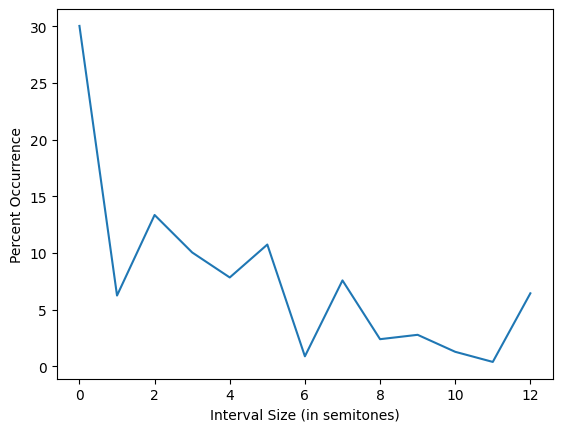

{'ascending': {1: 395252, 2: 839911, 3: 713957, 4: 556489, 5: 754024, 6: 58771, 7: 492667, 8: 156771, 9: 178353, 10: 72046, 11: 20177, 12: 426157}, 'descending': {1: 405338, 2: 871663, 3: 573827, 4: 448464, 5: 623138, 6: 54620, 7: 479047, 8: 150286, 9: 178114, 10: 92219, 11: 29689, 12: 399623}}


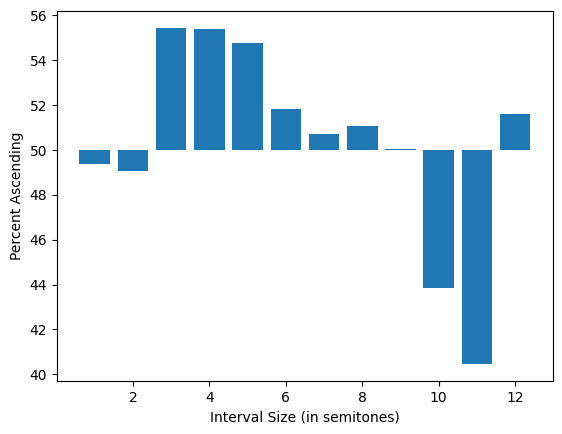

{'ascending': {'ascending': 2106786, 'descending': 1899068}, 'descending': {'ascending': 1783247, 'descending': 1848420}}


,,Followed by ascending step,Followed by descending step
0,Initial descending step,0.491027,0.508973
1,Initial ascending step,0.525927,0.474073


{'median-departing': {'same': 2126487, 'reverse': 1342250}, 'median-crossing': {'same': 4900627, 'reverse': 634478}, 'median-landing': {'same': 810440, 'reverse': 62367}, 'median-approaching': {'same': 1806438, 'reverse': 210661}}


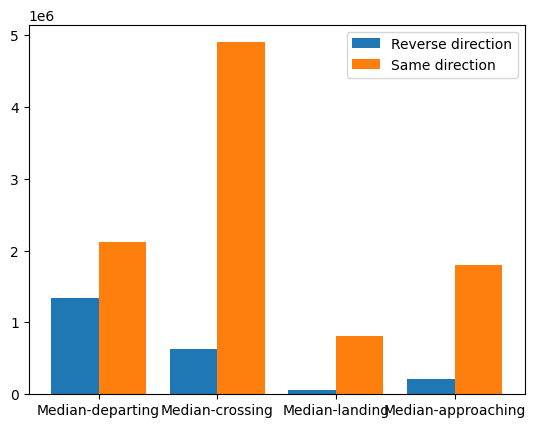

In [17]:
generate_frequency_of_intervals_graph(result[0][0])
generate_proportion_of_ascending_intervals_graph(result[0][1])
generate_step_step_movement_proportions_table(result[0][2])
generate_melodic_leap_stats_graph(result[0][3])